# Population Change 2020-2021

This notebook demonstrates how to query and merge the same data
set from different years. It also demonstrates how, behind the 
scenes, `censusdis` loads metadata and works across multiple
years. Nothing is hard-coded in the library about what variables
or data sets are available in what years. So when the 2021 data
was published, this notebook just worked.

In [1]:
# So we can run from within the censusdis project and find the packages we need.
import os
import sys

sys.path.append(
    os.path.join(os.path.abspath(os.path.join(os.path.curdir, os.path.pardir)))
)

## Imports and configuration

In [2]:
import censusdis.data as ced
import censusdis.maps as cem

In [3]:
DATASET = "acs/acs5"

In [4]:
TOTAL_POPULATION_VARIABLE = "B01003_001E"

## Download the popluation of the states in both years

In [5]:
gdf_states_2020 = ced.download_detail(
    DATASET, 2020, ["NAME", TOTAL_POPULATION_VARIABLE], state="*", with_geometry=True
)

# Note that we don't load the geometry here.
# We already have it above, and it will
# still be available after the merge.
df_states_2021 = ced.download_detail(
    DATASET, 2021, ["NAME", TOTAL_POPULATION_VARIABLE], state="*"
)

## Merge the two data sets and compute how the populations changed

In [6]:
gdf_both_years = gdf_states_2020.merge(
    df_states_2021, on=["STATE", "NAME"], suffixes=("_2020", "_2021")
)

In [7]:
TOTAL_POPULATION_2020_VARIABLE = f"{TOTAL_POPULATION_VARIABLE}_2020"
TOTAL_POPULATION_2021_VARIABLE = f"{TOTAL_POPULATION_VARIABLE}_2021"

TOTAL_POPULATION_CHANGE = f"{TOTAL_POPULATION_VARIABLE}_DELTA"
TOTAL_POPULATION_CHANGE_PERCENT = f"{TOTAL_POPULATION_CHANGE}_PERCENT"

In [8]:
gdf_both_years[TOTAL_POPULATION_CHANGE] = (
    gdf_both_years[TOTAL_POPULATION_2021_VARIABLE]
    - gdf_both_years[TOTAL_POPULATION_2020_VARIABLE]
)

gdf_both_years[TOTAL_POPULATION_CHANGE_PERCENT] = (
    100
    * gdf_both_years[TOTAL_POPULATION_CHANGE]
    / gdf_both_years[TOTAL_POPULATION_2020_VARIABLE]
)

## Fastest growing states

### Absolute

In [9]:
gdf_both_years.sort_values(TOTAL_POPULATION_CHANGE, ascending=False)[
    ["NAME", TOTAL_POPULATION_CHANGE]
].head()

,NAME,B01003_001E_DELTA
4,New York,599896
29,New Jersey,348606
24,Texas,227139
0,Pennsylvania,175765
7,Florida,122838


### Percentagewise

In [10]:
gdf_both_years.sort_values(TOTAL_POPULATION_CHANGE_PERCENT, ascending=False)[
    ["NAME", TOTAL_POPULATION_CHANGE_PERCENT]
].head()

,NAME,B01003_001E_DELTA_PERCENT
29,New Jersey,3.923349
19,Idaho,3.263285
42,Rhode Island,3.228499
4,New York,3.074049
32,Vermont,2.770446


## Fastest shrinking states

### Absolute

In [11]:
gdf_both_years.sort_values(TOTAL_POPULATION_CHANGE, ascending=True)[
    ["NAME", TOTAL_POPULATION_CHANGE]
].head()

,NAME,B01003_001E_DELTA
16,Arizona,-94861
33,North Carolina,-19205
5,District of Columbia,-18820
39,Mississippi,-14812
8,South Carolina,-12614


### Percentagewise

In [12]:
gdf_both_years.sort_values(TOTAL_POPULATION_CHANGE_PERCENT, ascending=True)[
    ["NAME", TOTAL_POPULATION_CHANGE_PERCENT]
].head()

,NAME,B01003_001E_DELTA_PERCENT
5,District of Columbia,-2.681011
16,Arizona,-1.322277
15,Wyoming,-0.809670
39,Mississippi,-0.496741
2,West Virginia,-0.352822


## Plot on maps

Text(0.5, 1.0, 'Total Population Change by State, 2020-2021')

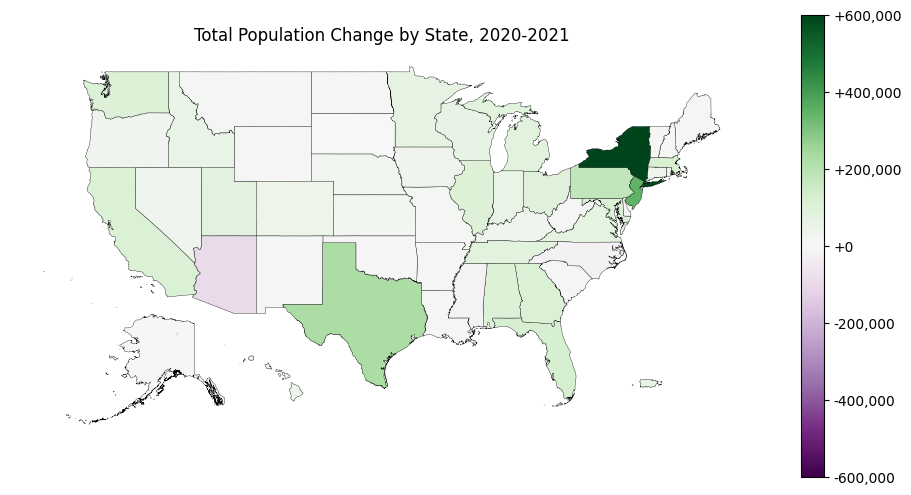

In [13]:
from matplotlib.ticker import FuncFormatter

ax = cem.plot_us(
    gdf_both_years,
    TOTAL_POPULATION_CHANGE,
    legend=True,
    figsize=(12, 6),
    cmap="PRGn",
    edgecolor="black",
    linewidth=0.25,
    vmin=-600_000,
    vmax=600_000,
    legend_kwds={"format": FuncFormatter(lambda x, pos: f"{x:+,.0f}")},
)

ax.axis("off")
ax.set_title("Total Population Change by State, 2020-2021")

Text(0.5, 1.0, 'Total Population Percentage Change by State, 2020-2021')

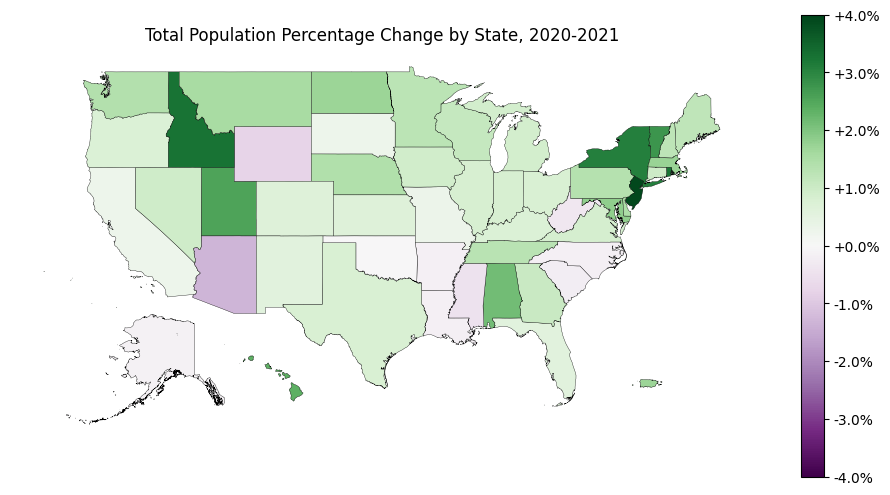

In [14]:
ax = cem.plot_us(
    gdf_both_years,
    TOTAL_POPULATION_CHANGE_PERCENT,
    legend=True,
    figsize=(12, 6),
    cmap="PRGn",
    edgecolor="black",
    linewidth=0.25,
    vmin=-4,
    vmax=4,
    legend_kwds={"format": FuncFormatter(lambda x, pos: f"{x:+.1f}%")},
)

ax.axis("off")
ax.set_title("Total Population Percentage Change by State, 2020-2021")